In [51]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models import tf_idf

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler




## load and clean data

In [52]:
def retrieve_combined_dataset(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')

    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    unit_df = db_manager.retrieve_units(city, state_abbr)
    merged_df = pd.merge(tf_idf_df, unit_df, on='UnitId', how='left')
    merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)

    return merged_df

In [53]:
df = retrieve_combined_dataset('austin', 'tx')

8


/tmp/ipykernel_95121/1047033042.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)


In [54]:
main_data = df[['Latitude','Longitude','Neighborhood','RentPrice','Beds','Baths','SquareFootage']]
main_data = main_data[main_data['RentPrice'].notna()]

lower_cap = main_data['RentPrice'].quantile(0.00)
upper_cap = main_data['RentPrice'].quantile(0.995)
main_data['RentPrice'] = main_data['RentPrice'].clip(lower_cap, upper_cap)

## General Statistics 

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(main_data.describe())


           Latitude     Longitude     RentPrice          Beds         Baths  \
count  39589.000000  39589.000000  39595.000000  39595.000000  39595.000000   
mean      30.326209    -97.738833   1768.461523      1.462609      1.420154   
std        0.097012      0.067857    628.360364      0.769575      0.555276   
min       30.116160    -98.036350    450.000000      0.000000      0.500000   
25%       30.247620    -97.773690   1359.000000      1.000000      1.000000   
50%       30.327420    -97.732040   1625.000000      1.000000      1.000000   
75%       30.401910    -97.698290   1996.000000      2.000000      2.000000   
max       30.520810    -97.569420   5350.000000     10.000000     10.000000   

       SquareFootage  
count   39556.000000  
mean      899.190843  
std       307.716820  
min       100.000000  
25%       691.000000  
50%       827.000000  
75%      1084.000000  
max      9980.000000  


## Distributions of Rent Prices

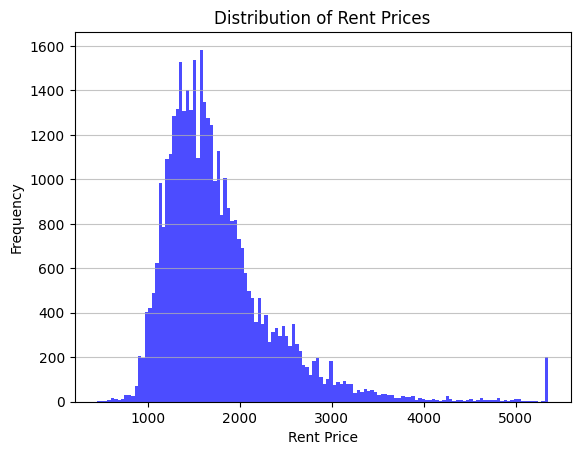

In [56]:

plt.hist(main_data['RentPrice'], bins='auto', color='blue', alpha=0.7)
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Basic Linear Regression

Text(0.5, 1.0, 'Rent vs. Square Footage')

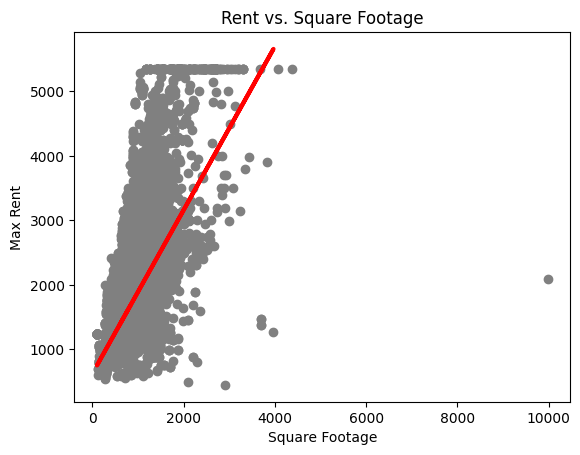

In [57]:
lin_regress_data = main_data[main_data['SquareFootage'].notna()]

X = lin_regress_data[['SquareFootage']]
y = lin_regress_data['RentPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(lin_regress_data['SquareFootage'], lin_regress_data['RentPrice'], color='grey')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Predicted Rent')
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.title('Rent vs. Square Footage')

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

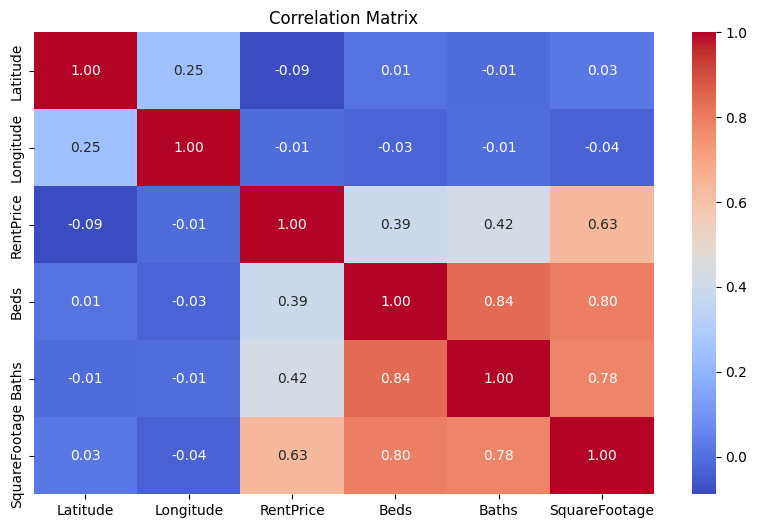

In [58]:
plt.figure(figsize=(10,6))
corr_matrix = main_data.drop(columns=['Neighborhood']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')


## Visual Mapping
Visualizing Neighborhoods based on rent and amount

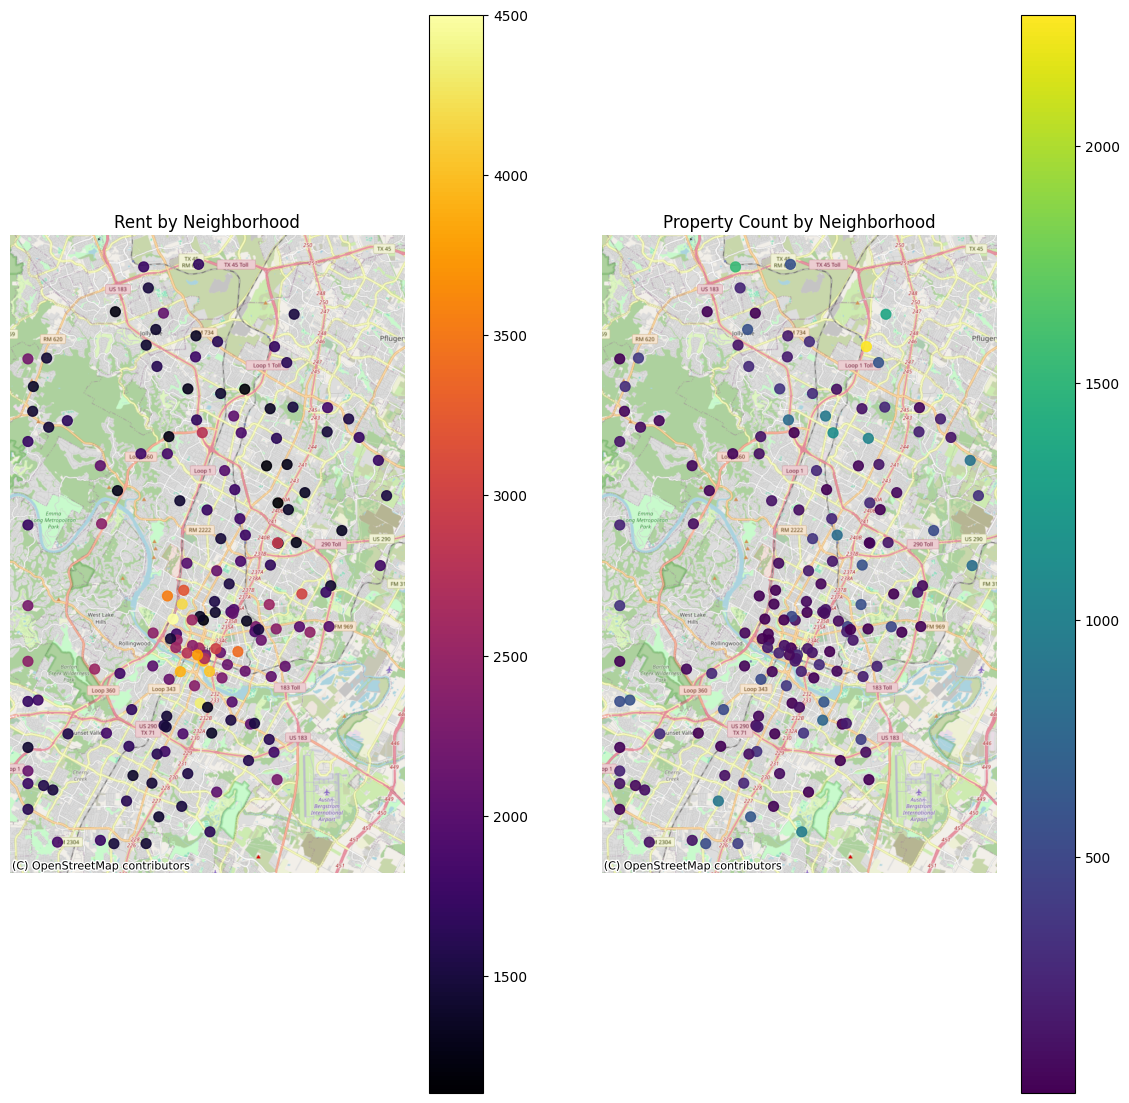

In [59]:
# Handle miscaculated lat long from addresses
lower_cap = main_data['Latitude'].quantile(0.05)
upper_cap = main_data['Latitude'].quantile(0.95)
main_data['Latitude'] = main_data['Latitude'].clip(lower_cap, upper_cap)

lower_cap = main_data['Longitude'].quantile(0.05)
upper_cap = main_data['Longitude'].quantile(0.95)
main_data['Longitude'] = main_data['Longitude'].clip(lower_cap, upper_cap)

# Get meta-data for neighborhoods
neighborhoods = main_data.groupby('Neighborhood').agg(
    MaxRent_Mean=('RentPrice', 'mean'),
    MaxRent_Std=('RentPrice', 'std'),
    Latitude_Mean=('Latitude', 'mean'),
    Longitude_Mean=('Longitude', 'mean'),
    Property_Count=('Neighborhood', 'size')
)

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(neighborhoods['Longitude_Mean'], neighborhoods['Latitude_Mean'])]
gdf = gpd.GeoDataFrame(neighborhoods, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))

# Plot 1: Heatmap based on MaxRent_Mean
gdf.plot(ax=ax1, marker='o', column='MaxRent_Mean', cmap='inferno', legend=True, markersize=50, alpha=0.9)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title('Rent by Neighborhood')

# Plot 2: Heatmap based on Property_Count
gdf.plot(ax=ax2, marker='o', column='Property_Count', cmap='viridis', legend=True, markersize=50, alpha=0.9)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title('Property Count by Neighborhood')


plt.show()

## K Means Clustering

to visualize the data, data is projected onto the top two Principle components and then clustering is performed 

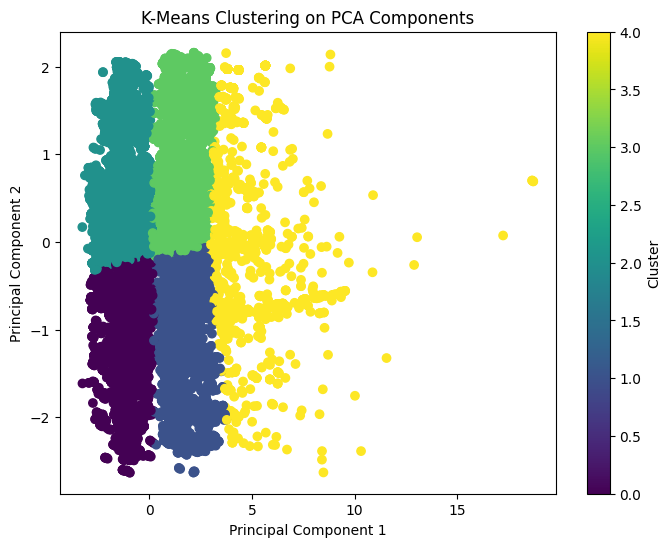

In [60]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(main_data.drop(columns=['Neighborhood']).dropna())

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=5, random_state=42)  
kmeans.fit(principal_components)
clusters = kmeans.labels_

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Step 5: Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering on PCA Components')
plt.colorbar(label='Cluster')
plt.show()